In [1]:
# Cell 1: Install (if needed) and imports
!pip install -q xgboost  # Colab: installs xgboost if not present

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb

# plotting defaults
%matplotlib inline
plt.rcParams['figure.figsize'] = (10,6)
sns.set(style='whitegrid')


In [2]:
# Cell 2: Load the CSV from the GitHub permalink (use raw URL)
# Original permalink (blob) -> convert to raw:
blob_url = "https://github.com/akash-dj/Maritime-Fleet-Optimization-under-Regulatory-Uncertainty/blob/3a891b7c65440e52bfed096c1934afc8037e9c39/ship_fuel_efficiency.csv"
raw_url = blob_url.replace("/blob/", "/raw/")

df = pd.read_csv(raw_url)
df.head()


,ship_id,ship_type,route_id,month,distance,fuel_type,fuel_consumption,CO2_emissions,weather_conditions,engine_efficiency
0,NG001,Oil Service Boat,Warri-Bonny,January,132.26,HFO,3779.77,10625.76,Stormy,92.14
1,NG001,Oil Service Boat,Port Harcourt-Lagos,February,128.52,HFO,4461.44,12779.73,Moderate,92.98
2,NG001,Oil Service Boat,Port Harcourt-Lagos,March,67.30,HFO,1867.73,5353.01,Calm,87.61
3,NG001,Oil Service Boat,Port Harcourt-Lagos,April,71.68,Diesel,2393.51,6506.52,Stormy,87.42
4,NG001,Oil Service Boat,Lagos-Apapa,May,134.32,HFO,4267.19,11617.03,Calm,85.61


In [3]:
# Cell 3: Quick checks and basic cleaning
print("Rows, cols:", df.shape)
df.info()
df.describe(include='all')


Rows, cols: (1440, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1440 entries, 0 to 1439
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ship_id             1440 non-null   object 
 1   ship_type           1440 non-null   object 
 2   route_id            1440 non-null   object 
 3   month               1440 non-null   object 
 4   distance            1440 non-null   float64
 5   fuel_type           1440 non-null   object 
 6   fuel_consumption    1440 non-null   float64
 7   CO2_emissions       1440 non-null   float64
 8   weather_conditions  1440 non-null   object 
 9   engine_efficiency   1440 non-null   float64
dtypes: float64(4), object(6)
memory usage: 112.6+ KB


,ship_id,ship_type,route_id,month,distance,fuel_type,fuel_consumption,CO2_emissions,weather_conditions,engine_efficiency
count,1440,1440,1440,1440,1440.000000,1440,1440.000000,1440.000000,1440,1440.000000
unique,120,4,4,12,NaN,2,NaN,NaN,3,NaN
top,NG001,Oil Service Boat,Port Harcourt-Lagos,January,NaN,Diesel,NaN,NaN,Calm,NaN
freq,12,408,389,120,NaN,899,NaN,NaN,516,NaN
mean,NaN,NaN,NaN,NaN,151.753354,NaN,4844.246535,13365.454882,NaN,82.582924
std,NaN,NaN,NaN,NaN,108.472230,NaN,4892.352813,13567.650118,NaN,7.158289
min,NaN,NaN,NaN,NaN,20.080000,NaN,237.880000,615.680000,NaN,70.010000
25%,NaN,NaN,NaN,NaN,79.002500,NaN,1837.962500,4991.485000,NaN,76.255000
50%,NaN,NaN,NaN,NaN,123.465000,NaN,3060.880000,8423.255000,NaN,82.775000
75%,NaN,NaN,NaN,NaN,180.780000,NaN,4870.675000,13447.120000,NaN,88.862500


In [4]:
# Cell 4: Simulate carbon prices (Geometric Brownian Motion)
def simulate_carbon_price(n_months, S0=80.0, mu=0.05, sigma=0.40, random_seed=None):
    """Simulate EU ETS carbon price trajectory (monthly GBM)."""
    if random_seed is not None:
        np.random.seed(random_seed)
    dt = 1/12
    prices = [S0]
    for _ in range(n_months-1):
        shock = np.random.normal()
        new_price = prices[-1] * np.exp((mu - 0.5*sigma**2)*dt + sigma*np.sqrt(dt)*shock)
        prices.append(new_price)
    return np.array(prices)

# produce prices for 12 months or for unique months in the dataset
unique_months = sorted(df['month'].unique())
n_months = len(unique_months)
carbon_prices = simulate_carbon_price(n_months, S0=80.0, mu=0.05, sigma=0.40, random_seed=42)

# map months to simulated prices
month_to_price = dict(zip(unique_months, carbon_prices))
df['carbon_price_eur'] = df['month'].map(month_to_price)


In [5]:
# Cell 5: Apply regulatory phase-in factor phi (0.4, 0.7, 1.0) per year as in docx.
# For demonstration, map month->year via month integer (this is synthetic mapping).
# In the docx: 2025->0.4 (for 2024 emissions), 2026->0.7 (for 2025 emissions), 2027->1.0.
# We'll create a synthetic 'year' column if missing.

if 'year' not in df.columns:
    # assume dataset months correspond to a 2025-2027 span cyclically if not provided
    # map months 1-12 to 2025 for simplicity (user can replace with real year)
    df['year'] = 2025

def phase_in_phi(year):
    if year == 2025:
        return 0.4
    elif year == 2026:
        return 0.7
    elif year >= 2027:
        return 1.0
    else:
        return 0.0

df['regulatory_phi'] = df['year'].apply(phase_in_phi)

# CO2 emissions column expected in dataset; docx uses CO2_emissions
# If file has fuel burn only, convert to CO2 using factor Cf ~ 3.114 tCO2 / t fuel (document)
if 'CO2_emissions' not in df.columns and 'fuel_consumption' in df.columns:
    # fuel_consumption assumed in tonnes -> CO2 in kg or tonnes? docx uses tCO2/t fuel
    df['CO2_emissions'] = df['fuel_consumption'] * 3.114  # tonnes CO2

# tax liability = CO2_emissions * carbon_price_eur * regulatory_phi
df['tax_liability_eur'] = df['CO2_emissions'] * df['carbon_price_eur'] * df['regulatory_phi']


In [6]:
# Cell 6: enrich_data_with_physics (speed, duration, fuel, and numeric weather proxies)
def enrich_data_with_physics(row):
    # --- 1. Speed and Fuel Logic ---
    ship_type = str(row.get('ship_type', '')).strip()

    # Assign realistic operating speeds based on vessel class
    if 'Surfer' in ship_type:
        speed = np.random.uniform(20, 35)   # Planing hull (fast)
    elif 'Tanker' in ship_type:
        speed = np.random.uniform(10, 14)   # Displacement hull (slow/steady)
    else:  # Trawler or Oil Service
        speed = np.random.uniform(8, 12)    # Moderate speed

    # Calculate duration and derived fuel rate
    distance = row.get('distance', np.nan)
    if pd.isna(distance) or distance == 0:
        duration = np.nan
        fuel_per_hr = np.nan
    else:
        duration = distance / speed
        fuel = row.get('fuel_consumption', np.nan)
        if pd.isna(fuel) or duration == 0:
            fuel_per_hr = np.nan
        else:
            fuel_per_hr = fuel / duration

    # --- 2. Environmental Proxies (Weather & Sea State) ---
    # Convert categorical labels into physics-based numeric proxies
    weather = row.get('weather_conditions', 'Moderate')

    if weather == 'Calm':
        # Small waves, light wind
        Hs = np.random.uniform(0.0, 0.5)    # Significant wave height (m)
        wind = np.random.uniform(0, 10)     # Wind speed (knots)
    elif weather == 'Moderate':
        # Average rough conditions
        Hs = np.random.uniform(0.5, 2.5)
        wind = np.random.uniform(10, 20)
    else: # Stormy
        # High waves, strong winds
        Hs = np.random.uniform(2.5, 6.0)
        wind = np.random.uniform(20, 40)

    # Synthesize Wind Direction (relative to ship heading)
    # Head seas increase resistance; Following seas decrease it.
    directions = ['Head', 'Beam', 'Following']
    wind_dir = np.random.choice(directions)

    return pd.Series({
        'speed_knots': speed,
        'duration_hrs': duration,
        'fuel_per_hour': fuel_per_hr,
        'wave_height_m': Hs,           # Numeric proxy for sea state
        'wind_speed_kts': wind,        # Numeric proxy for wind force
        'wind_direction': wind_dir     # Directional factor
    })

# Apply enrichment
# We drop existing columns if re-running to avoid duplicates
cols_to_drop = ['speed_knots', 'duration_hrs', 'fuel_per_hour',
                'wave_height_m', 'wind_speed_kts', 'wind_direction']
df = df.drop(columns=[c for c in cols_to_drop if c in df.columns], errors='ignore')

enriched = df.apply(enrich_data_with_physics, axis=1)
df = pd.concat([df, enriched], axis=1)

# Display the new physics-enriched features
df[['ship_type', 'weather_conditions', 'speed_knots', 'wave_height_m', 'wind_speed_kts', 'wind_direction']].head()

,ship_type,weather_conditions,speed_knots,wave_height_m,wind_speed_kts,wind_direction
0,Oil Service Boat,Stormy,9.216969,4.336648,28.638900,Head
1,Oil Service Boat,Moderate,10.099099,1.299722,10.466657,Following
2,Oil Service Boat,Calm,9.824280,0.392588,1.996738,Following
3,Oil Service Boat,Stormy,11.932924,4.133670,37.198808,Following
4,Oil Service Boat,Calm,8.682096,0.032526,9.488855,Beam


In [7]:
# Cell 7: Compute engine load fraction and a simple 'bathtub' SFOC penalty
# We need an assumed max engine rating or proxy. Use a synthetic max_power_tonnes_per_hr proxy.
# This is simplifying code consistent with the docx narrative.

# Synthetic max power proxy (tonnes fuel per hr at max rating) - user can adjust
df['engine_max_fuel_per_hr'] = df['fuel_per_hour'].max() * 1.5

# engine load fraction
df['engine_load_frac'] = df['fuel_per_hour'] / df['engine_max_fuel_per_hr']

# bathtub SFOC penalty: penalty factor increases if load <0.3 or >0.9 (docx describes penalty)
def sfoc_penalty(load):
    if pd.isna(load):
        return 1.0
    if load < 0.3:
        return 1.0 + (0.3 - load) * 0.5  # rising penalty at low load
    elif load > 0.9:
        return 1.0 + (load - 0.9) * 0.5  # penalty at very high load
    else:
        return 1.0  # near-optimal

df['sfoc_penalty'] = df['engine_load_frac'].apply(sfoc_penalty)

# fouling proxy: days_since_drydock synthetic if not present
if 'days_since_drydock' not in df.columns:
    df['days_since_drydock'] = np.random.randint(0, 365, size=len(df))

# fouling fuel multiplier (increase up to 15% for high fouling)
df['fouling_multiplier'] = 1.0 + (df['days_since_drydock'] / 365) * 0.15

# adjust fuel consumption with penalties (synthetic adjusted target)
df['fuel_consumption_adj'] = df['fuel_consumption'] * df['sfoc_penalty'] * df['fouling_multiplier']


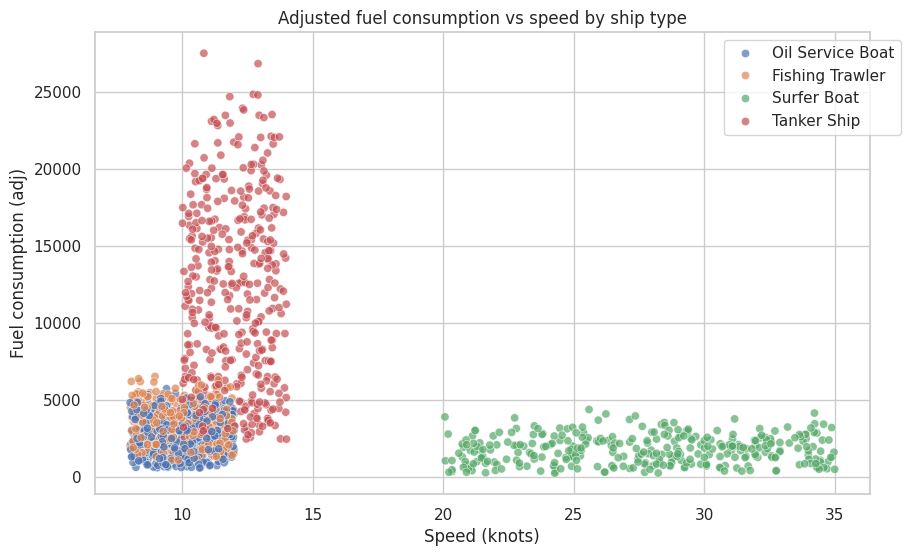

In [8]:
# Cell 8.1: EDA plots - fuel vs speed by ship_type
plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x='speed_knots', y='fuel_consumption_adj', hue='ship_type', alpha=0.7)
plt.title('Adjusted fuel consumption vs speed by ship type')
plt.xlabel('Speed (knots)')
plt.ylabel('Fuel consumption (adj)')
plt.legend(bbox_to_anchor=(1.05,1), loc='upper right')
plt.show()


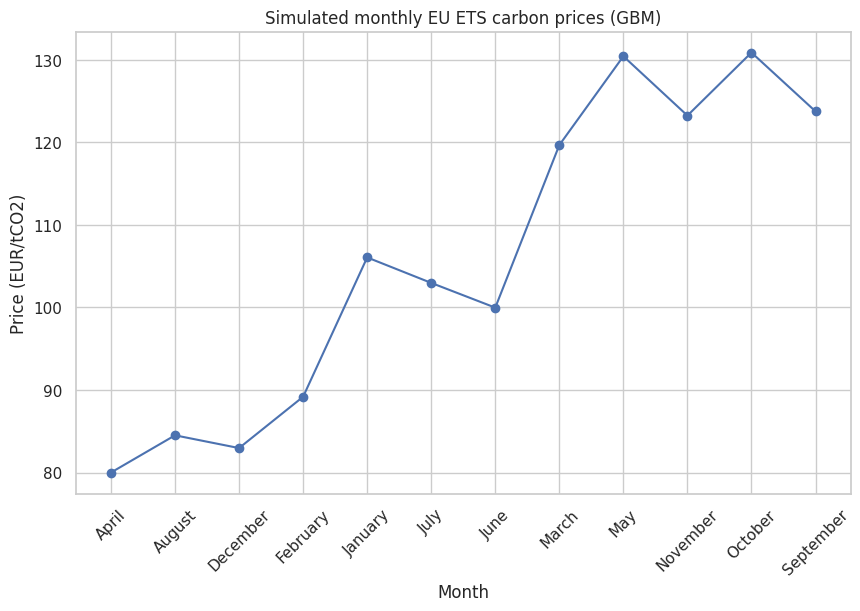

In [9]:
#Cell 8.2: Carbon price over simulated months
plt.figure(figsize=(10,6))
plt.plot(unique_months, carbon_prices, marker='o')
plt.title('Simulated monthly EU ETS carbon prices (GBM)')
plt.xlabel('Month')
plt.ylabel('Price (EUR/tCO2)')
plt.xticks(rotation=45) # Rotate x-axis labels
plt.grid(True)
plt.show()

In [10]:
# Cell 9: Prepare X and y
# Updated to use the physics-based numeric proxies instead of raw categories

# 1. Define the features to use (Include the numeric weather proxies here!)
feature_cols = [
    'speed_knots',
    'duration_hrs',
    'engine_load_frac',
    'sfoc_penalty',
    'fouling_multiplier',
    'carbon_price_eur',
    'regulatory_phi',
    'wave_height_m',   # Matches text Section 2
    'wind_speed_kts'   # Matches text Section 2
]

# 2. Handle categorical features (Ship Type & Wind Direction)
# We typically One-Hot Encode ship_type and wind_direction
cat_cols = []
if 'ship_type' in df.columns:
    cat_cols.append('ship_type')
if 'wind_direction' in df.columns: # Matches text "add a wind_direction feature"
    cat_cols.append('wind_direction')

# 3. Create Modeling DataFrame
df_model = df[feature_cols + cat_cols + ['fuel_consumption_adj']].copy()
df_model = pd.get_dummies(df_model, columns=cat_cols, drop_first=True)

# 4. Clean and Split
df_model = df_model.dropna()

X = df_model.drop(columns=['fuel_consumption_adj'])
y = df_model['fuel_consumption_adj'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("Features used:", X.columns.tolist())

Train shape: (1152, 14) Test shape: (288, 14)
Features used: ['speed_knots', 'duration_hrs', 'engine_load_frac', 'sfoc_penalty', 'fouling_multiplier', 'carbon_price_eur', 'regulatory_phi', 'wave_height_m', 'wind_speed_kts', 'ship_type_Oil Service Boat', 'ship_type_Surfer Boat', 'ship_type_Tanker Ship', 'wind_direction_Following', 'wind_direction_Head']


In [11]:
# Cell 10: Linear Regression baseline
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)
print(f"Linear Regression RMSE: {rmse_lr:.4f}, R2: {r2_lr:.4f}")


Linear Regression RMSE: 1054.1143, R2: 0.9644


In [12]:
# Cell 11: XGBoost model (champion) - with Monotonic Constraints
import xgboost as xgb

# Define monotonic constraints
# We enforce a positive constraint (+1) on speed: higher speed must lead to higher (or equal) fuel.
# This ensures the model respects the laws of physics.
monotone_constraints = {"speed_knots": 1}

xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=500,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    # Pass the dictionary mapping feature names to constraint directions
    monotone_constraints=monotone_constraints
)

# Fit the model
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False # Keep verbose=False to suppress training output
)

y_pred_xgb = xgb_model.predict(X_test)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)
print(f"XGBoost RMSE: {rmse_xgb:.4f}, R2: {r2_xgb:.4f}")

XGBoost RMSE: 417.7101, R2: 0.9944


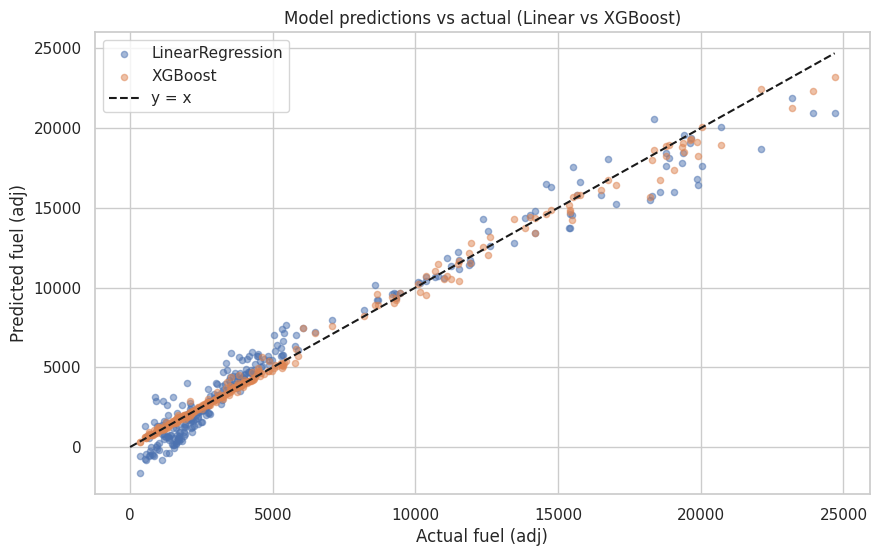

In [13]:
# Cell 12: Plot actual vs predicted for both models
plt.figure()
plt.scatter(y_test, y_pred_lr, alpha=0.5, label='LinearRegression', s=20)
plt.scatter(y_test, y_pred_xgb, alpha=0.5, label='XGBoost', s=20)
maxv = max(y_test.max(), y_pred_xgb.max(), y_pred_lr.max())
plt.plot([0, maxv], [0, maxv], 'k--', label='y = x')
plt.xlabel('Actual fuel (adj)')
plt.ylabel('Predicted fuel (adj)')
plt.legend()
plt.title('Model predictions vs actual (Linear vs XGBoost)')
plt.show()


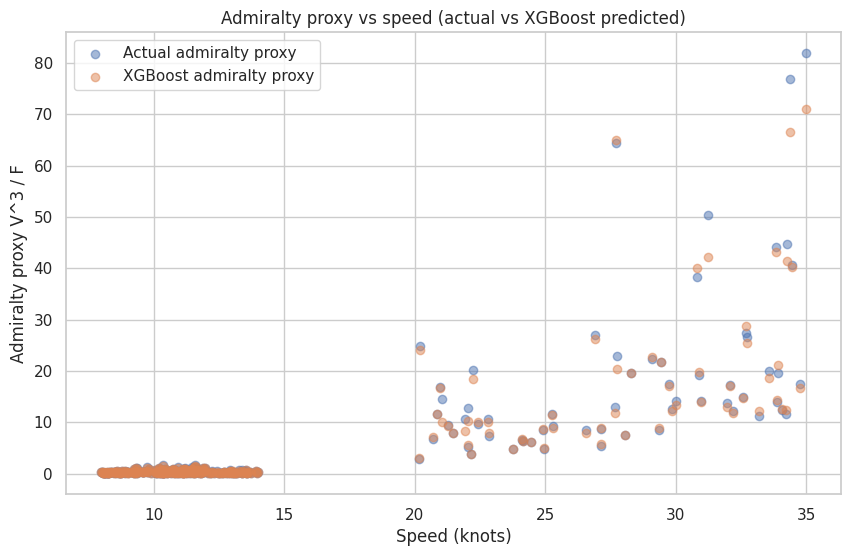

In [14]:
# Cell 13: Admiralty proxy computation and plot
# Use test set inputs to compute proxy from actual and predicted fuel
# Need speed column index from X_test
if 'speed_knots' in X.columns:
    speed_test = X_test['speed_knots'].values
    admiralty_actual = (speed_test**3) / y_test
    admiralty_pred_xgb = (speed_test**3) / y_pred_xgb

    plt.figure()
    plt.scatter(speed_test, admiralty_actual, alpha=0.5, label='Actual admiralty proxy')
    plt.scatter(speed_test, admiralty_pred_xgb, alpha=0.5, label='XGBoost admiralty proxy')
    plt.xlabel('Speed (knots)')
    plt.ylabel('Admiralty proxy V^3 / F')
    plt.legend()
    plt.title("Admiralty proxy vs speed (actual vs XGBoost predicted)")
    plt.show()
else:
    print("speed_knots not in model features; cannot compute admiralty proxy.")



=== Oil Service Boat ===
Realistic speed range: 8–12 knots
Optimal speed: 12.00 knots
Estimated minimum cost: 2317175.78 USD


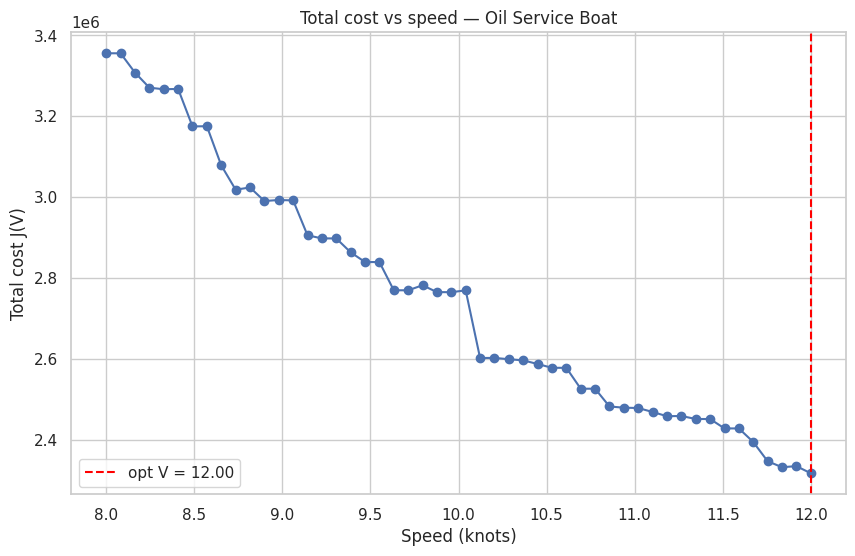


=== Fishing Trawler ===
Realistic speed range: 8–12 knots
Optimal speed: 11.84 knots
Estimated minimum cost: 1442266.85 USD


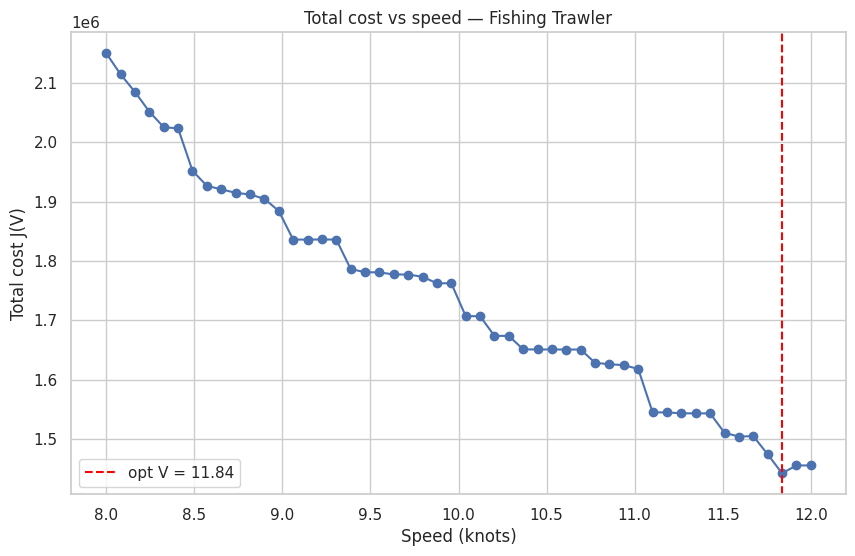


=== Surfer Boat ===
Realistic speed range: 20–35 knots
Optimal speed: 35.00 knots
Estimated minimum cost: 1075269.15 USD


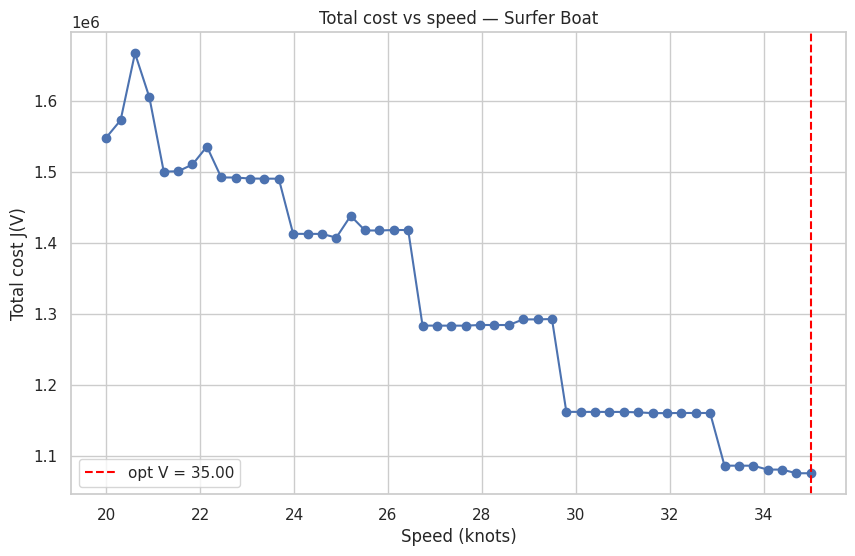


=== Tanker Ship ===
Realistic speed range: 10–15 knots
Optimal speed: 15.00 knots
Estimated minimum cost: 10369720.03 USD


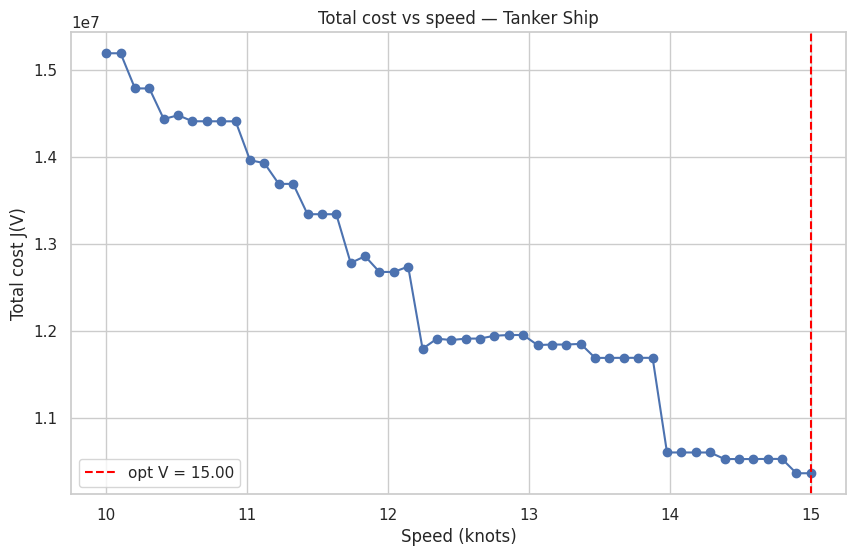



### Optimal Speeds Summary ###
Oil Service Boat: Optimal speed = 12.00 knots, Cost = 2317175.78 USD
Fishing Trawler: Optimal speed = 11.84 knots, Cost = 1442266.85 USD
Surfer Boat: Optimal speed = 35.00 knots, Cost = 1075269.15 USD
Tanker Ship: Optimal speed = 15.00 knots, Cost = 10369720.03 USD


In [15]:
# Cell 14: Optimize speed for every ship type

# Economic parameters
P_fuel = 600.0          # USD/tonne fuel
Cf = 3.114              # tonnes CO2 per tonne fuel
TCE_per_day = 20000.0   # USD/day revenue

# Realistic speed ranges for each ship type
def get_speed_range(ship_type):
    ship_type = str(ship_type).lower()

    if "tanker" in ship_type:
        return 10, 15
    elif "trawler" in ship_type or "fishing" in ship_type:
        return 8, 12
    elif "oil service" in ship_type:
        return 8, 12
    elif "surfer" in ship_type:
        return 20, 35
    else:
        return 8, 14

# Store results
results = []

# Loop over each ship type
for stype in df['ship_type'].unique():
    subset = df[df['ship_type'] == stype]

    # pick a valid sample row with distance and model features
    sample = subset.dropna(subset=['distance'])
    if len(sample) == 0:
        continue

    sample_idx = sample.index[0]
    sample_row = df.loc[sample_idx]

    D = sample_row['distance']
    V_min, V_max = get_speed_range(stype)

    # create speed grid
    Vs = np.linspace(V_min, V_max, 50)
    costs = []
    preds = []

    base_features = X.loc[sample_idx].copy()

    for V in Vs:
        duration = D / V
        feat = base_features.copy()
        feat['speed_knots'] = V
        feat['duration_hrs'] = duration

        F_hat = xgb_model.predict(feat.values.reshape(1, -1))[0]
        preds.append(F_hat)

        carbon_price = sample_row['carbon_price_eur']
        phi = sample_row['regulatory_phi']

        J = (
            P_fuel * F_hat +
            carbon_price * Cf * phi * F_hat +
            (D / V) * (TCE_per_day / 24)
        )
        costs.append(J)

    best_idx = np.argmin(costs)
    best_V = Vs[best_idx]
    best_cost = costs[best_idx]

    results.append((stype, best_V, best_cost))

    print(f"\n=== {stype} ===")
    print(f"Realistic speed range: {V_min}–{V_max} knots")
    print(f"Optimal speed: {best_V:.2f} knots")
    print(f"Estimated minimum cost: {best_cost:.2f} USD")

    # Optional: plot results
    plt.figure(figsize=(10,6))
    plt.plot(Vs, costs, marker='o')
    plt.axvline(best_V, color='red', linestyle='--', label=f'opt V = {best_V:.2f}')
    plt.xlabel('Speed (knots)')
    plt.ylabel('Total cost J(V)')
    plt.title(f'Total cost vs speed — {stype}')
    plt.legend()
    plt.grid(True)
    plt.show()

# Display summary table
print("\n\n### Optimal Speeds Summary ###")
for stype, v, c in results:
    print(f"{stype}: Optimal speed = {v:.2f} knots, Cost = {c:.2f} USD")
